In [2]:
import torch
from qer.ai.hemorrhages import Hemorrhages2DBlend
import pandas as pd
from monai.data import Dataset
from torch.utils.data import DataLoader
import monai
import random
from typing import Any, Dict, List, Sequence, Union, Tuple, Optional

import numpy as np
import SimpleITK as sitk
import torch
import time
from loguru import logger
from monai.transforms import (
    DivisiblePadd,
    RandomizableTransform,
    Transform,
    Resize
)
from torch.nn.functional import interpolate
from skimage.transform import rescale
from pydicom import dcmread
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import h5py
from tqdm.auto import tqdm
from scipy import ndimage as ndi
import os
import torch
from qer.utils.db import get_mongo_db
db = get_mongo_db()
from qer.utils.imageoperations.resampler import load_raw_sitk_img
from monai.data import Dataset
import copy
import skimage.segmentation as skimg_segm
import sqlite3
from qer.ai.predictor.get_predictions import load_and_run_model
from skimage.morphology import skeletonize
from skimage.filters import median

import cv2
import skimage
from skimage.morphology import ball , disk , binary_erosion , binary_dilation, binary_closing, binary_opening
from scipy import stats
import matplotlib.pyplot as plt
from itertools import combinations




Unable to find logging config yaml. Configuring fallback values


In [3]:
from ipywidgets import widgets
from ipywidgets import interact


def plot_scans(img_arr_list, title_list):
    cols = len(img_arr_list)
    num_slices = img_arr_list[0].shape[0]

    def callback(z=None):
        fig, ax = plt.subplots(1, cols, figsize=(5*cols, 5*cols), squeeze=False)
        for idx in range(cols):
            ax[0][idx].imshow(img_arr_list[idx][z, :, :], cmap='gray')
            ax[0][idx].title.set_text(title_list[idx])
            ax[0][idx].axis('off')
            ax[0][idx].grid(False)

        fig.tight_layout()
        fig.show()

    interact(
        callback,
        z=widgets.IntSlider(value=0, min=0, max=(num_slices - 1), step=1)
    )

In [4]:
class Point(object):
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

    def random(self, min= 0, max= 1):
        self.x = random.uniform(min,max)
        self.y = random.uniform(min,max)

class QuadBezier(object):
    def __init__(self, p0x= 0, p0y= 0, p1x= 0, p1y= 0, p2x= 0, p2y= 0):
        self.p0 = Point(p0x, p0y)
        self.p1 = Point(p1x, p1y)
        self.p2 = Point(p2x, p2y)

    def calc_curve(self, granuality=100):
        'Calculate the quadratic Bezier curve with the given granuality.'
        B_x = []
        B_y = []
        for t in range(0, granuality):
            t = t / granuality
            x = self.p1.x + (1 - t)**2 * (self.p0.x-self.p1.x) + t**2 * (self.p2.x - self.p1.x)
            y = self.p1.y + (1 - t)**2 * (self.p0.y-self.p1.y) + t**2 * (self.p2.y - self.p1.y)
            B_x.append(x)
            B_y.append(y)
        return [B_x, B_y]

In [5]:
from qer.utils.preprocessing.windowing import window_generator
brain_window = window_generator(80 , 40)
blood_window = window_generator(175 , 50)
bone_window = window_generator(3000 , 500)

In [564]:
path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/hemorrhage_annotations.sqlite"
con = sqlite3.connect(path)
df_hemorrhage_mask = pd.read_sql_query("SELECT * from hemorrhage_annotations", con)
con.close()

In [566]:
df_hemorrhage_mask.StudyUID.values[0]

'1.2.840.113619.2.55.3.2831165748.828.1418003997.173'

In [581]:
import sqlite3
root_dir = "/data_nas3/processed/hct/Cache/all_imgs_cache.dcm/"

path = "/home/users/shubham.kumar/projects/ICH_classification_segmentation/qct_training_framework/hemorrhage_annotations.sqlite"
con = sqlite3.connect(path)
df_hemorrhage_mask = pd.read_sql_query("SELECT * from hemorrhage_annotations", con)
con.close()


def get_mask_arr_path(study_uid):
    rows = df_hemorrhage_mask[df_hemorrhage_mask.StudyUID == study_uid]
    if len(rows) > 0:
        study_uid = rows.iloc[0].StudyUID
        mask_path = rows.iloc[0].MaskPath[:-7]
        filepath = os.path.join(root_dir, mask_path)
        filenames = []
        for slice_ in range(len(os.listdir(filepath))):
            slice_num = (3 - len(str(slice_))) * "0" + str(slice_)
            data_path = os.path.join(filepath, f"image_{slice_num}.dcm")
            filenames.append(data_path)
        return filenames
    return -100

series_dict = db.dicoms.find_one({"_id": df_hemorrhage_mask.SeriesUID.values[0]})
filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]

sitk_img = load_raw_sitk_img(filepaths)
sdh_arr = sitk.GetArrayFromImage(sitk_img)

dcm_paths = get_mask_arr_path(df_hemorrhage_mask.StudyUID.values[0])
arr_list = [dcmread(dcm_path).pixel_array for dcm_path in dcm_paths]
sdh_mask_arr = np.array(arr_list)
hu_values = sdh_arr[binary_erosion(sdh_mask_arr,ball(1)) > 0].ravel()


params = stats.gamma.fit(hu_values)

        

[2023-08-28 02:36:50 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.08 to 5.08


ImageSeriesReader (0x112ee0a60): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000516129



In [579]:
params = stats.gamma.fit(hu_values)


In [582]:
params

(328.5292564674929, -90.53601685038265, 0.47700904381184084)

In [573]:
plot_scans([brain_window(sdh_arr),sdh_mask_arr] , ["",""])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [561]:
sdh_mask_arr.shape

(30, 512, 512)

In [569]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")


In [571]:
df_hemorrhage_mask[df_hemorrhage_mask["StudyUID"] == '1.2.840.113619.2.55.3.2831165748.828.1418003997.173'].SDH

2064    1
Name: SDH, dtype: int64

In [567]:
'1.2.840.113619.2.55.3.2831165748.828.1418003997.173'


'1.2.840.113619.2.55.3.2831165748.828.1418003997.173'

In [557]:
df_hemorrhage_mask[df_hemorrhage_mask["SDH"] ==1]

,Filepath_x,StudyUID,SeriesUID_x,NumSlices_x,Verified,Batch_x,MaskPath,MaskType,Intensity,PatientID,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
2,batch_2/sampled/1.2.840.113619.2.81.290.1.5987...,1.2.840.113619.2.81.290.1.5987.20141219.262709,1.2.840.113619.2.81.290.1.5987.2.20141219.262851,30,1,batch_2,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute,MDI12450,...,1,0,0,0.0,1,"[[0, 29], [36, 474], [92, 440]]",61.0,GE MEDICAL SYSTEMS,False,batch_2/sampled/1.2.840.113619.2.81.290.1.5987...
3,batch_6/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165748.921.144652233...,1.2.840.113619.2.55.3.2831165748.921.144652233...,38,1,batch_6,sah_fine_annot_2020-01-22/1.2.840.113619.2.55....,fine,not acute,SHM28901,...,1,0,0,0.0,1,"[[0, 37], [68, 472], [106, 422]]",28.0,GE MEDICAL SYSTEMS,False,batch_6/sampled/1.2.840.113619.2.55.3.28311657...
11,neha_mixed_2017-07-24/sampled/WAR53551.nii.gz,1.2.840.10008.1.914890.1884609602.3216610268.1...,1.2.840.113619.2.55.3.2831165736.266.140110244...,48,1,neha_mixed_2017-07-24,combined_hemorrhage_annotations/neha_mixed_201...,fine,not acute,WAR53551,...,1,0,0,0.0,1,"[[0, 46], [4, 420], [78, 390]]",25.0,GE MEDICAL SYSTEMS,False,batch_15/sampled/1.2.840.10008.1.914890.188460...
25,neha_subdural_2017-07-13/sampled/TVL79055.nii.gz,1.2.840.113619.2.81.290.1.7678.20150213.273305,1.2.840.113619.2.81.290.1.7678.2.20150213.273357,48,1,neha_subdural_2017-07-13,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute,TVL79055,...,1,0,0,0.0,1,"[[0, 24], [62, 484], [94, 410]]",35.0,GE MEDICAL SYSTEMS,False,batch_15/sampled/1.2.840.113619.2.81.290.1.767...
28,batch_1/sampled/1.2.840.113619.2.278.3.2831165...,1.2.840.113619.2.278.3.2831165736.278.13454159...,1.2.840.113619.2.278.3.2831165736.923.13454161...,44,1,batch_1,combined_hemorrhage_annotations/b1_all_hmgs/1....,coarse,not acute,WAR19668,...,1,0,0,0.0,1,"[[0, 44], [10, 444], [84, 432]]",40.0,GE MEDICAL SYSTEMS,False,batch_1/sampled/1.2.840.113619.2.278.3.2831165...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,batch_2/sampled/1.2.840.113619.2.81.290.9059.6...,1.2.840.113619.2.81.290.9059.6855.20150514.230807,1.2.840.113619.2.81.290.9059.6855.4.20150514.2...,38,1,batch_2,sdh_minimal_train_2020-02-27/1.2.840.113619.2....,fine,not acute,MLD20979,...,1,0,0,1.0,1,"[[0, 35], [80, 452], [100, 396]]",5.0,GE MEDICAL SYSTEMS,False,batch_2/sampled/1.2.840.113619.2.81.290.9059.6...
2376,nishant_subdural_2017-07-19/sampled/CLU400388....,1.2.840.113619.2.334.3.2831165721.869.14085026...,1.2.840.113619.2.334.3.2831165721.869.14085026...,32,1,nishant_subdural_2017-07-19,combined_hemorrhage_annotations/nishant_subdur...,fine,not acute,CLU400388,...,1,0,0,0.0,1,"[[0, 31], [32, 468], [100, 444]]",65.0,GE MEDICAL SYSTEMS,False,batch_13/sampled/1.2.840.113619.2.334.3.283116...
2377,nishant_subdural_2017-07-19/sampled/TCY146344....,1.2.840.10008.1.95409.1190104320.1391907976.45...,1.2.840.113619.2.284.3.2831168021.475.13865363...,32,1,nishant_subdural_2017-07-19,combined_hemorrhage_annotations/nishant_subdur...,fine,not acute,TCY146344,...,1,0,0,0.0,1,"[[0, 30], [36, 460], [94, 426]]",23.0,GE MEDICAL SYSTEMS,False,batch_16/sampled/1.2.840.10008.1.95409.1190104...
2381,batch_10/sampled/1.2.840.10008.1.390041.764627...,1.2.840.10008.1.390041.764627507.309872793.205...,1.2.840.113619.2.284.3.2831165716.377.14085861...,36,1,batch_10,sdh_minimal_train_2020-02-27/1.2.840.10008.1.3...,fine,not acute,KLP96398,...,1,0,0,0.0,1,"[[0, 31], [8, 370], [104, 398]]",67.0,GE MEDICAL SYSTEMS,False,batch_10/sampled/1.2.840.10008.1.390041.764627...


In [554]:
hu_values

array([41, 48, 57, ..., 66, 65, 62], dtype=int32)

In [473]:
df_hemorrhage_mask

,Filepath,StudyUID,SeriesUID,NumSlices,Verified,Batch,MaskPath,MaskType,Intensity
0,neha_subdural_2017-07-10/sampled/SHM20089.nii.gz,1.2.840.113619.2.55.3.2831165748.828.141800399...,1.2.840.113619.2.55.3.2831165748.828.141800399...,32,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,acute
1,neha_subdural_2017-07-10/sampled/KLP287527.nii.gz,1.2.840.113619.2.334.3.2831165716.247.14522211...,1.2.840.113619.2.334.3.2831165716.247.14522211...,67,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
2,neha_subdural_2017-07-10/sampled/KUH67733.nii.gz,1.2.840.113619.2.55.3.2831165733.122.141159310...,1.2.840.113619.2.55.3.2831165733.122.141159310...,36,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
3,neha_subdural_2017-07-10/sampled/WAR29701.nii.gz,1.2.840.113619.2.278.3.2831165736.379.13616763...,1.2.840.113619.2.278.3.2831165736.379.13616763...,28,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
4,neha_subdural_2017-07-10/sampled/SHM5418.nii.gz,1.2.840.113619.2.278.3.2831165748.855.13502706...,1.2.840.113619.2.278.3.2831165748.855.13502706...,32,1,neha_subdural_2017-07-10,combined_hemorrhage_annotations/neha_subdural_...,fine,not acute
...,...,...,...,...,...,...,...,...,...
3639,batch_15/sampled/1.2.840.113619.2.81.290.1.463...,1.2.840.113619.2.81.290.1.4630.20140519.181042,1.2.840.113619.2.81.290.1.4630.2.20140519.181153,33,1,batch_15,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3640,batch_0/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165742.194.144444358...,1.2.840.113619.2.55.3.2831165742.194.144444358...,30,1,batch_0,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3641,batch_16/sampled/1.2.840.113619.2.81.290.1.440...,1.2.840.113619.2.81.290.1.4405.20150516.272106,1.2.840.113619.2.81.290.1.4405.2.20150516.272200,32,1,batch_16,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute
3642,batch_18/sampled/1.2.840.113619.2.55.3.2831165...,1.2.840.113619.2.55.3.2831165752.134.136927493...,1.2.840.113619.2.55.3.2831165752.18.1369279437...,28,1,batch_18,mixedmask_corrections_2020-05-05/1.2.840.11361...,fine,not acute


In [337]:
df_annot_fda = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/qquantFDA_ICH_annot.csv")





In [429]:
list(set(df_annot_fda.columns) - set(["StudyUID"]))

{'anu_rao',
 'anu_rao_fda',
 'dr_avinash_fda',
 'reader1',
 'reader2',
 'reader2_new',
 'reader3',
 'reader4',
 'reader5',
 'reader6',
 'reader7'}

In [ ]:
new_filepaths = [filepath.replace( "/data_nas2/processed/HeadCT/" , "/data_nas3/processed/hct/")  for filepath in filepaths]


In [584]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165748.914.1510195757.743.h5","r")

In [585]:
arr5 = f2["image"]

In [587]:
f2.close()

In [589]:
arr5.shape

(34, 512, 512)

In [624]:
# Normal CT scan
series_dict = db.dicoms.find_one({"_id": '1.2.840.113619.2.284.3.2831168021.160.1374282537.443'})
filepaths = [x['FilePath'] for x in series_dict["InstancesList"]]
filepaths = [filepath.replace( "/data_nas2/raw/" , "/data_nas3/raw/hct/")  for filepath in filepaths]
sitk_img = load_raw_sitk_img(filepaths)
arr = sitk.GetArrayFromImage(sitk_img)

def get_mls_icv(sitk_img):
    output = load_and_run_model("mls_helper_icv_quant",sitk_img)
    icv_mask = output['results']['heatmaps']['ICV']
    icv_mask_arr = sitk.GetArrayFromImage(icv_mask)
    midline_output = load_and_run_model("mls_quantification" ,sitk_img)
    mls_arr = sitk.GetArrayFromImage(midline_output['results']['heatmaps']['MLS'])
    
    return mls_arr , icv_mask_arr

[2023-08-28 03:37:10 +0530] [INFO] Correcting image z spacing using median of slice positions from 5.00 to 5.00


In [625]:
def get_thick_contour(icv_mask_arr , thickness):
    eroded_icv_mask_arr = binary_dilation(icv_mask_arr.copy())
    for i in range(eroded_icv_mask_arr.shape[0]):
        eroded_icv_mask_arr[i] = binary_erosion(icv_mask_arr[i], disk(thickness))
    contour = icv_mask_arr-eroded_icv_mask_arr
    return contour

In [626]:
mls_arr , icv_mask_arr = get_mls_icv(sitk_img)
contour = get_thick_contour(icv_mask_arr , 8)

[2023-08-28 03:37:15 +0530] [INFO] Loading model mls_helper_icv_quant
[2023-08-28 03:37:16 +0530] [INFO] Loading model mls_quantification
[2023-08-28 03:37:16 +0530] [INFO] Loading model mls_helper_icv_quant
[2023-08-28 03:37:17 +0530] [INFO] Loading model mls_helper_lv_quant


In [627]:
slices_to_pick = np.unique(np.argwhere(mls_arr ==1)[:,0])

In [628]:
random.shuffle(slices_to_pick)
slice_to_pick = slices_to_pick[0]

In [629]:
# select one slice of CT
req_image  = arr[slice_to_pick]  # 2d image
req_mls_arr = mls_arr[slice_to_pick]
req_icv_mask = icv_mask_arr[slice_to_pick]
req_contour = contour[slice_to_pick]


In [630]:
plot_scans([brain_window(arr), icv_mask_arr , contour ,mls_arr] , ["","","",""])

interactive(children=(IntSlider(value=0, description='z', max=35), Output()), _dom_classes=('widget-interact',…

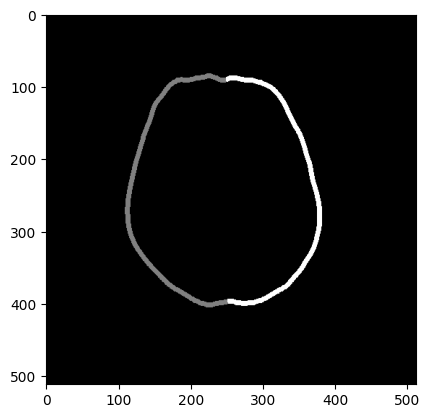

In [631]:
# Define two points (x1, y1) and (x2, y2)
def get_hemi_contour(req_image, req_mls_arr, req_icv_mask, req_contour) : 

    ml_coordinates = np.argwhere(req_mls_arr==1)
    (x1,y1) = ml_coordinates[0]
    (x2,y2) = ml_coordinates[-1]

    # Calculate the slope (m) and y-intercept (b)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Create an empty mask
    seperator_mask = np.zeros(req_contour.shape, dtype=np.uint8)

    for x in range(req_contour.shape[0]):
        for y in range(req_image.shape[1]):
            if y >= m * x + b:
                seperator_mask[x, y] = 2
            else :
                seperator_mask[x, y] = 1

    final_image_to_work = seperator_mask*req_contour
    return final_image_to_work


final_image_to_work = get_hemi_contour(req_image, req_mls_arr, req_icv_mask, req_contour)
plt.imshow(final_image_to_work, cmap='gray')
plt.show()


In [632]:
# Identify edge pixels
def get_icv_edge(req_icv_mask) : 
    icv_edges = req_icv_mask.copy()
    edge_mask = cv2.Canny(icv_edges.astype(np.uint8), 0, 1)  # Using Canny edge detection

    # Dilate the edge pixels to make the edges thicker
    kernel_size = 2  # Adjust this to control the thickness of the edges
    dilated_edge_mask = cv2.dilate(edge_mask, np.ones((kernel_size, kernel_size), np.uint8))

    # Set the intensity of the thickened edge pixels to a new value (3)
    thick_edge_intensity = 3
    icv_edges[dilated_edge_mask > 0] = thick_edge_intensity
    icv_edges = (icv_edges == 3)*1
    return icv_edges

icv_edges = get_icv_edge(req_icv_mask)

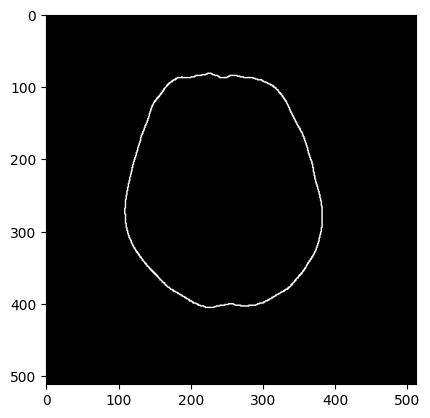

In [633]:
plt.imshow(icv_edges, cmap='gray')
plt.show()

In [634]:
# Function to calculate distance between two points
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def get_coordinates(final_image_to_work , side = "left" , section = "frontal", num_segments = 3):
    if side == "left" :
        hemisphere_strip = (final_image_to_work == 1)*1
    if side == "right" :
        hemisphere_strip = (final_image_to_work == 2)*1
        
    # Find indices of non-zero elements (curve pixels)
    curve_indices = np.argwhere(hemisphere_strip == 1)

    # Define the ratios for the three sections
    ratio_section1 = 0.32
    ratio_section2 = 0.36
    ratio_section3 = 0.32

    # Calculate total number of curve pixels
    total_pixels = len(curve_indices)

    # Calculate lengths of the three sections
    length_section1 = int(total_pixels * ratio_section1)
    length_section2 = int(total_pixels * ratio_section2)
    length_section3 = total_pixels - length_section1 - length_section2

    # Divide the curve indices into three sections
    section1_indices = curve_indices[:length_section1]
    section2_indices = curve_indices[length_section1:length_section1+length_section2]
    section3_indices = curve_indices[length_section1+length_section2:]
   
    section_mask = np.zeros_like(hemisphere_strip)

    for idx in section1_indices:
        section_mask[idx[0], idx[1]] = 1

    for idx in section2_indices:
        section_mask[idx[0], idx[1]] = 2

    for idx in section3_indices:
        section_mask[idx[0], idx[1]] = 3
        
    plt.imshow(section_mask,cmap ="gray")  # Use vmin and vmax to match region labels
    plt.show()
    
    if section == "frontal" :
        req_coordinates = np.argwhere((section_mask == 1)*1*icv_edges )
        
    if section == "temporal" :
        req_coordinates = np.argwhere((section_mask == 2)*1*icv_edges )
    
    if section == "occipital" :
        req_coordinates = np.argwhere((section_mask == 3)*1*icv_edges )
        

    # Calculate the step size based on the number of segments
    step_size = len(req_coordinates) // num_segments

    # Calculate the indices for the segmented points
    indices = [step_size * i for i in range(num_segments)] + [len(req_coordinates) - 1]

    # Get the coordinates of the segmented points
    segmented_points = [req_coordinates[indices[i]:indices[i+1]+1] for i in range(num_segments)]

    max_distance_coordinates = []

    # Find the pair of coordinates with maximum distance in each segment
    for segment in segmented_points:
        pairs = combinations(segment, 2)
        max_distance_pair = max(pairs, key=lambda pair: distance(pair[0], pair[1]))
        max_distance_coordinates.append(max_distance_pair)
        
    return max_distance_coordinates

In [635]:
hemisphere_side = "left"
section = "frontal"
num_segments = 6
segments_to_pick = 6


In [636]:
random.choice(np.arange(num_segments))

3

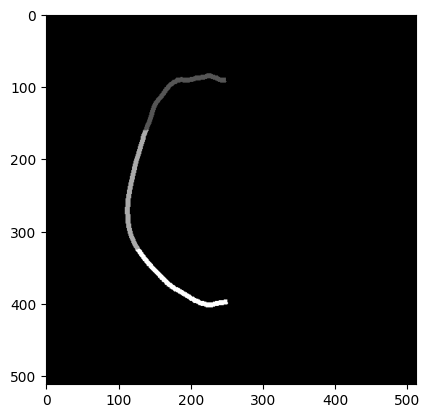

[135 144] [160 135]


In [637]:
final_image_to_work_with_enhance_edges = final_image_to_work.copy()
final_image_to_work_with_enhance_edges[icv_edges==1] = 3


# plt.figure(figsize=(6, 6))
# plt.imshow(icv_edges, cmap='gray')
# plt.title('Edges')
# plt.colorbar()
# plt.show()

# # Display the original mask with edges enhanced
# plt.figure(figsize=(6, 6))
# plt.imshow(final_image_to_work_with_enhance_edges, cmap='gray')
# plt.title('Mask with Enhanced Edges')
# plt.colorbar()
# plt.show()

final_coordinates = get_coordinates(final_image_to_work , side = hemisphere_side , section = section, num_segments=num_segments)

point1 ,point2 = final_coordinates[segments_to_pick-1]

print(point1 ,point2)


def get_point_on_perp_bisector(point1,point2,hemisphere_side,distance) :
    
    x1,y1 = point1 
    x2,y2 = point2
    # Calculate the midpoint between the two given points
    midpoint = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    intersection_x , intersection_y = midpoint
    
    original_slope = (y2 - y1)/(x2-x1)
    perpendicular_slope = -1 / original_slope
        
    # Calculate the angle of the line with respect to the x-axis
    theta = np.arctan(perpendicular_slope)

    # Calculate the x and y components of the desired points
    dx = distance * np.cos(theta)
    dy = distance * np.sin(theta)

    # Calculate the two points on the perpendicular bisector
    point1_perpendicular = (int(intersection_x + dx), int(intersection_y + dy))
    point2_perpendicular = (int(intersection_x - dx), int(intersection_y - dy))
    
    if hemisphere_side == "left" :
        return point1_perpendicular
    if hemisphere_side == "right" : 
        return point2_perpendicular
    
#     return point1_perpendicular , point2_perpendicular



In [525]:
sitk_img.GetSize()

(512, 512, 36)

In [638]:
# Find indices of non-zero elements (curve pixels)

def get_all_section(hemisphere_strip) : 
    curve_indices_left = np.argwhere(hemisphere_strip == 1)
    curve_indices_right = np.argwhere(hemisphere_strip == 2)

    # Define the ratios for the three sections
    ratio_section1 = 0.32
    ratio_section2 = 0.36
    ratio_section3 = 0.32

    # Calculate total number of curve pixels
    total_pixels_left = len(curve_indices_left)
    total_pixels_right = len(curve_indices_right)

    # Calculate lengths of the three sections
    length_section1_left = int(total_pixels_left * ratio_section1)
    length_section2_left = int(total_pixels_left * ratio_section2)
    length_section3_left = total_pixels_left - length_section1 - length_section2
    
    length_section1_right = int(total_pixels_right * ratio_section1)
    length_section2_right = int(total_pixels_right * ratio_section2)
    length_section3_right = total_pixels_right - length_section1 - length_section2

    # Divide the curve indices into three sections
    section1_indices_left = curve_indices_left[:length_section1_left]
    section2_indices_left = curve_indices_left[length_section1_left:length_section1_left+length_section2_left]
    section3_indices_left = curve_indices_left[length_section1_left+length_section2_left:]
    
    # Divide the curve indices into three sections
    section1_indices_right = curve_indices_right[:length_section1_right]
    section2_indices_right = curve_indices_right[length_section1_right:length_section1_right+length_section2_right]
    section3_indices_right = curve_indices_right[length_section1_right+length_section2_right:]

    section_mask = np.zeros_like(hemisphere_strip)

    for idx in section1_indices_left:
        section_mask[idx[0], idx[1]] = 1

    for idx in section2_indices_left:
        section_mask[idx[0], idx[1]] = 2

    for idx in section3_indices_left:
        section_mask[idx[0], idx[1]] = 3
        
    for idx in section1_indices_right:
        section_mask[idx[0], idx[1]] = 4

    for idx in section2_indices_right:
        section_mask[idx[0], idx[1]] = 5

    for idx in section3_indices_right:
        section_mask[idx[0], idx[1]] = 6
        
    return section_mask


In [639]:
int(slice_to_pick)

21

In [640]:
sitk_img[:,:, int(slice_to_pick)]

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f11c9e9d690> >

In [644]:
import scipy

0
1
2
3
4
5
6
[2023-08-28 14:53:20 +0530] [INFO] Loading model hemorrhages_quantification


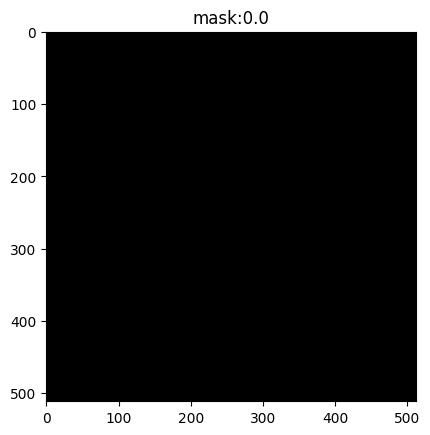

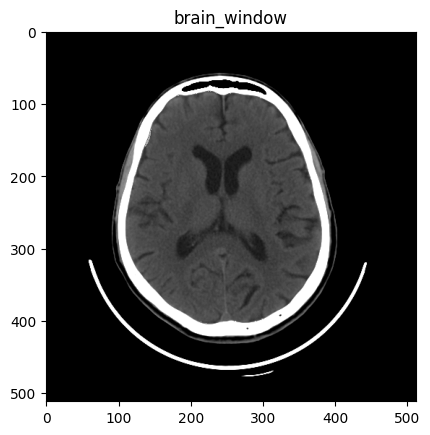

7
[2023-08-28 14:53:22 +0530] [INFO] Loading model hemorrhages_quantification


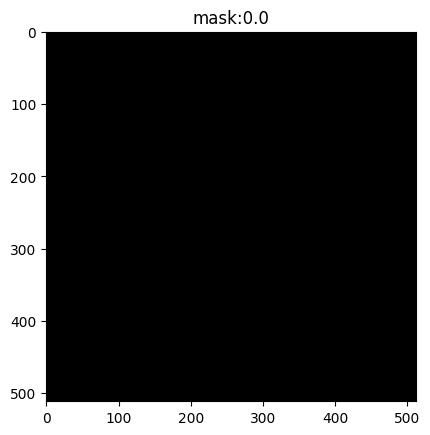

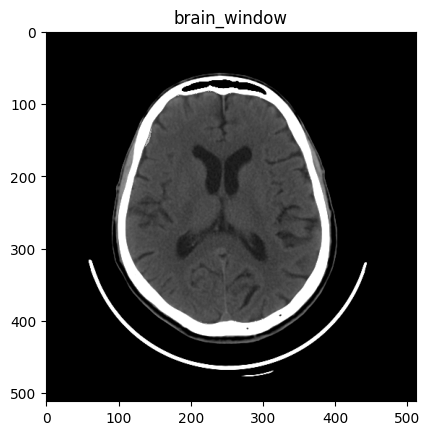

8
[2023-08-28 14:53:24 +0530] [INFO] Loading model hemorrhages_quantification


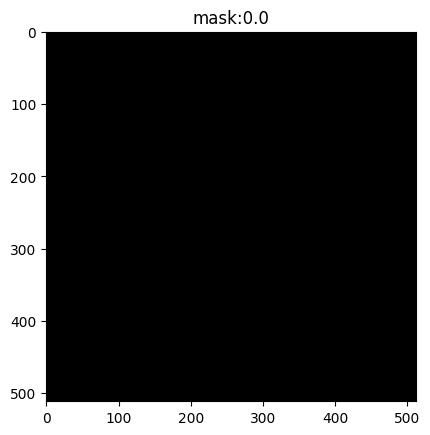

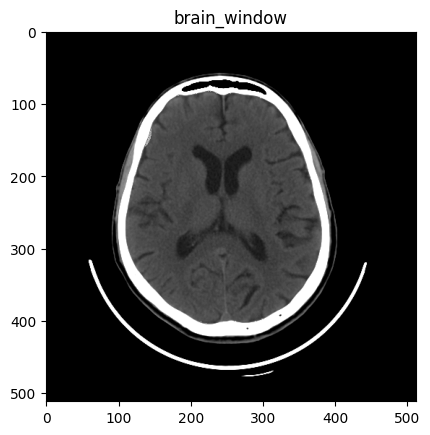

9
[2023-08-28 14:53:26 +0530] [INFO] Loading model hemorrhages_quantification


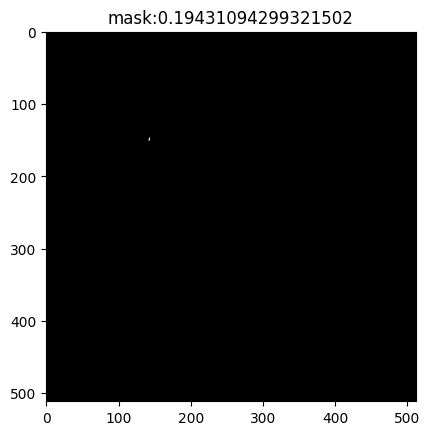

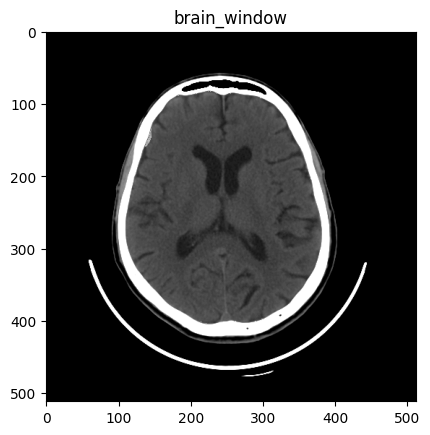

10
[2023-08-28 14:53:28 +0530] [INFO] Loading model hemorrhages_quantification


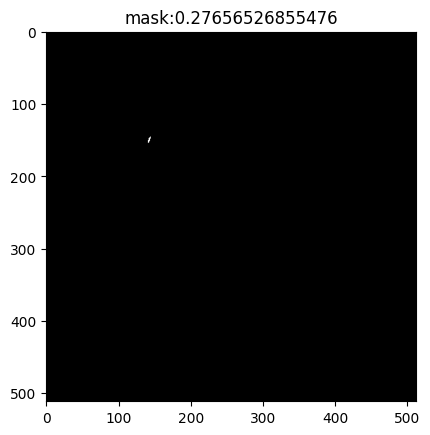

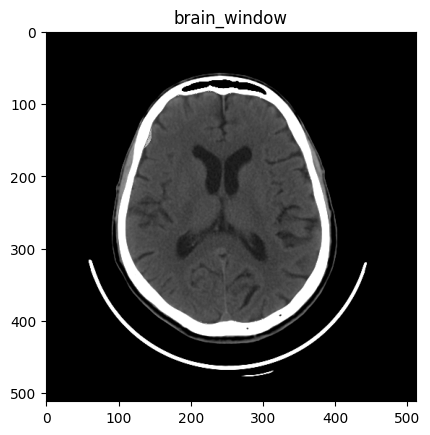

11
[2023-08-28 14:53:30 +0530] [INFO] Loading model hemorrhages_quantification


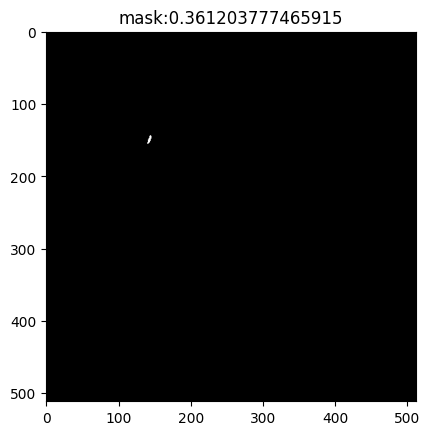

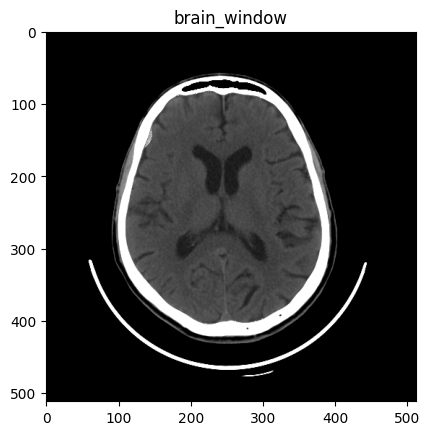

12
[2023-08-28 14:53:32 +0530] [INFO] Loading model hemorrhages_quantification


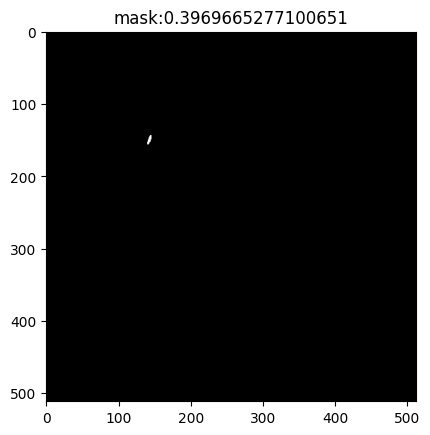

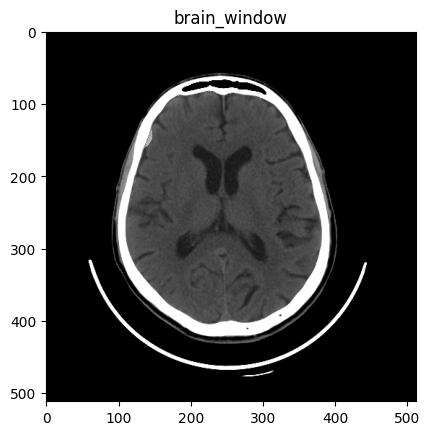

13
[2023-08-28 14:53:34 +0530] [INFO] Loading model hemorrhages_quantification


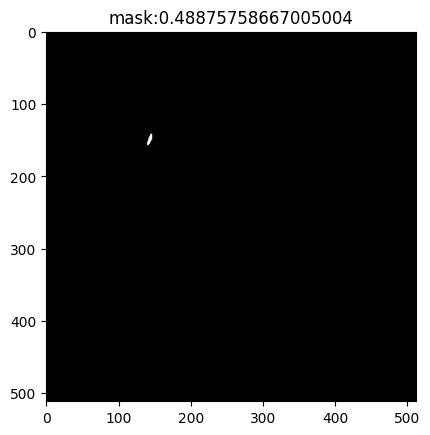

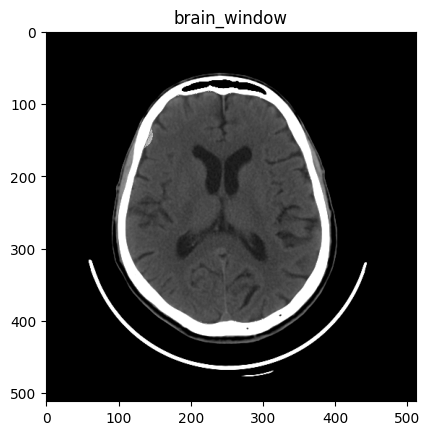

14
[2023-08-28 14:53:36 +0530] [INFO] Loading model hemorrhages_quantification


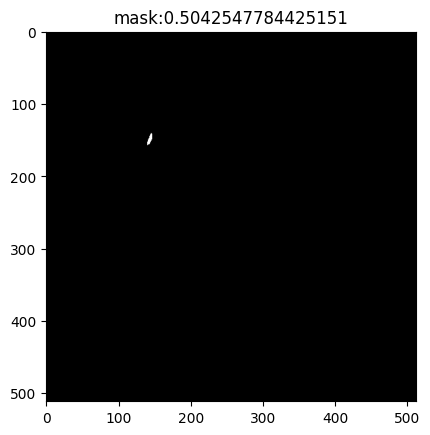

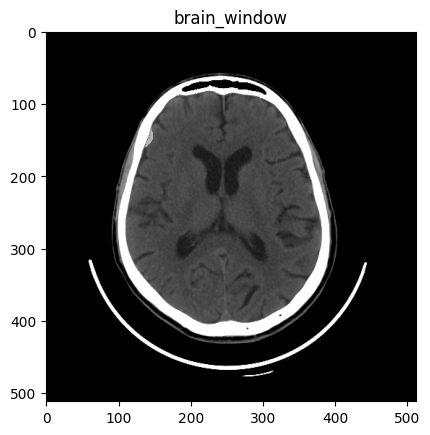

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [667]:
for perp_dist in range(0,30) : 
    print(perp_dist)
    point_perpendicular =  get_point_on_perp_bisector(point1,point2,hemisphere_side , perp_dist)

    curve = QuadBezier(p0x = point1[0], p0y = point1[1],p1x = point_perpendicular[0] , p1y = point_perpendicular[1],
                      p2x = point2[0] , p2y = point2[1])

    final_curve = curve.calc_curve()
    curve_coordinates = zip(final_curve[0],final_curve[1])
    

    final_curve_mask = np.zeros(final_image_to_work.shape)
    
    dummy = final_image_to_work_with_enhance_edges.copy()
    
    valid_curve = True
    
    for pair in curve_coordinates :
        final_curve_mask[int(pair[0])][int(pair[1])] = 3
        if dummy[int(pair[0])][int(pair[1])] == 0 :
            valid_curve = False
            break
            
    kernel_size = 2  # Adjust this to control the thickness of the edges
    dilated_curve_mask = cv2.dilate(final_curve_mask, np.ones((kernel_size, kernel_size), np.uint8))
    
    dummy[dilated_curve_mask == 3] = 3
    
    final_artificial_sdh_mask = binary_closing(dummy == 3 , disk(5)) - icv_edges
    
    
    median_filter_mask =  binary_dilation(final_artificial_sdh_mask,disk(3))
    
    
    
    rejector = binary_opening(final_artificial_sdh_mask.copy() , disk(1))*req_icv_mask
        
    if np.sum(rejector) == 0 :
        valid_curve = False
        
    if valid_curve : 
        
       
        
#         plt.imshow(final_artificial_sdh_mask,cmap ="gray")  # Use vmin and vmax to match region labels
#         plt.show()
    
        synthetic_data = stats.gamma.rvs(*params, size=np.sum(final_artificial_sdh_mask > 0))
        # Apply the generated HU values to the binary mask
        generated_hu_image = np.zeros(final_artificial_sdh_mask.shape)
        generated_hu_image[final_artificial_sdh_mask > 0] = synthetic_data.astype(np.int16)
        
#         plt.figure(figsize=(6, 6))
#         plt.imshow(generated_hu_image, cmap='gray')
#         plt.show()


        blur_kernel_size = 1
        blurred_gaussian_image = cv2.GaussianBlur(generated_hu_image, (blur_kernel_size, blur_kernel_size), 0)
        blurred_gaussian_image = blurred_gaussian_image.astype(arr[slice_to_pick].dtype)
        
        # Alpha blend the blurred Gaussian image and the original image
        alpha = 0.5  # Adjust this value for the desired blending strength
        blended_image = cv2.addWeighted(req_image, 1 - alpha, blurred_gaussian_image, alpha, 5)
        
        
        
        blended_sitk_img = sitk.GetImageFromArray(blended_image)
        blended_sitk_img.SetSpacing(sitk_img[:,:, int(slice_to_pick)].GetSpacing())
        blended_sitk_img.SetOrigin(sitk_img[:,:, int(slice_to_pick)].GetOrigin())
        blended_sitk_img.SetDirection(sitk_img[:,:, int(slice_to_pick)].GetDirection())
                
        sitk_img[:,:, int(slice_to_pick)]  = blended_sitk_img
        
        results = load_and_run_model("hemorrhages_quantification",sitk_img)
        mask = sitk.GetArrayFromImage(results['results']['heatmaps']['ICH'])
        
        
        
        for mask_idx in range(mask.shape[0]):
            if 1 in np.unique(mask[mask_idx])  :
                break
        
        plt.imshow(mask[mask_idx], cmap='gray')
        plt.title(f"mask:{results['results']['quantification value']['ICH']}")
        plt.show()
        

#         plt.figure(figsize=(6, 6))
        plt.imshow(brain_window(blended_image), cmap='gray')
        plt.title("brain_window")
        plt.show()
        
#         plt.imshow(mask[slice_to_pick], cmap='gray')
#         plt.title(f"mask:{np.sum(mask[slice_to_pick])}")
#         plt.show()





In [ ]:
def get_largest_island(mask):
    """Extracts the largest island (in terms of number of voxels/pixels) in the mask"""

    th = mask.sum()

    new_value = 1
    largest_island_key = 1
    island = {}
    flooded_mask = mask

    max_size = 0
    sum_size = 0

    while len(np.argwhere(flooded_mask == 1)) > 0:
        seed_points = np.argwhere(flooded_mask == 1)
        new_value = new_value + 1

        flooded_mask = flood_fill(flooded_mask, tuple(seed_points[-1]), new_value)

        island[new_value] = len(np.argwhere(flooded_mask == new_value))

        if island[new_value] > th // 2:
            largest_island_key = new_value
            break

        sum_size += island[new_value]

        if max_size < island[new_value]:
            max_size = island[new_value]
            largest_island_key = new_value

        if max_size > th - sum_size:
            break

    cleaned_mask = np.zeros_like(mask)
    cleaned_mask[flooded_mask == largest_island_key] = 1

    return cleaned_mask




In [445]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165733.145.1415066935.912.h5", "r")


In [447]:
f2["mask"].shape

(36, 512, 512)

In [448]:
di = {"StudyUID" : 2}

In [449]:
isinstance(di , dict)

True

In [102]:
df_quant_SDH_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_train_outputs.csv")



In [103]:
df_quant_SDH_train

,StudyUID,SeriesUID,region,volume,unit
0,1.2.840.10008.1.501323.1190104320.381065622.16...,1.2.840.113619.2.284.3.2831168021.160.13742825...,4.0,6.276363,ml
1,1.2.840.113619.2.55.3.2831165748.582.137426886...,1.2.840.113619.2.55.3.2831165748.582.137426886...,1.0,200.873368,ml
2,1.2.840.113619.2.81.290.1.475.20130720.220334,1.2.840.113619.2.81.290.1.475.2.20130720.220526,6.0,0.272989,ml
3,1.2.840.10008.1.145279.1884609602.322825990.19...,1.2.840.113619.2.55.3.2831165736.692.138792935...,5.0,18.011313,ml
4,1.2.840.113619.2.278.3.2831165736.843.13253661...,1.2.840.113619.2.278.3.2831165736.843.13253661...,5.0,3.710981,ml
...,...,...,...,...,...
7710,1.3.12.2.1107.5.1.7.106839.3000001905200940285...,1.3.12.2.1107.5.1.7.106839.3000001905201123273...,4.0,18.679711,ml
7711,1.3.12.2.1107.5.1.7.106839.3000001905210842314...,1.3.12.2.1107.5.1.7.106839.3000001905211004477...,NaN,0.000000,ml
7712,1.3.12.2.1107.5.1.7.106839.3000001905220738218...,1.3.12.2.1107.5.1.7.106839.3000001905221847424...,4.0,1.986177,ml
7713,1.3.12.2.1107.5.1.7.106839.3000001905230820562...,1.3.12.2.1107.5.1.7.106839.3000001905231251155...,4.0,27.915383,ml


In [468]:
df_dataset_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")



In [480]:
a = set(df_dataset_train[(df_dataset_train["NORMAL_BRAIN"]==1) & df_dataset_train["CONFIRMED_HCT"] == 1].StudyUID.values)



In [481]:
b = set(df_hemorrhage_mask.StudyUID.values)

In [483]:
c = list(a - b)

In [486]:
len(c)

115251

In [543]:
pd.DataFrame(c,columns=["StudyUID"]).to_csv("train_normal_ncct.csv",index =False)

In [544]:
pwd

'/home/users/shubham.kumar/projects/qct_training_framework/notebooks'

In [488]:
import random

In [489]:
random.shuffle(c)

In [485]:
df_dataset_train[df_dataset_train["StudyUID"] == c[1]]

,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
37402,1.2.840.113619.2.81.290.1.223.20130519.271808,VIR2064,train,batch_8/sampled/1.2.840.113619.2.81.290.1.223....,1.2.840.113619.2.81.290.1.223.2.20130519.271914,batch_8,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 23], [82, 490], [102, 420]]",10.0,GE MEDICAL SYSTEMS,False,batch_8/sampled/1.2.840.113619.2.81.290.1.223....


In [490]:
c[0:3000]

['1.2.840.113619.2.81.290.8017.36464.20110420.242304',
 '1.3.12.2.1107.5.1.4.40318.4.0.1350760817157416',
 '1.2.840.113619.2.55.3.2831165735.352.1471816812.10',
 '1.2.840.113619.2.278.3.2831165748.812.1354669039.302',
 '1.2.840.113619.2.55.3.2831165721.739.1324178009.666',
 '1.2.840.10008.1.691306.1884609602.318054770.1997003586',
 '1.3.12.2.1107.5.1.4.34169.4.0.6858979929601063',
 '1.2.840.113619.2.55.3.2831165735.897.1386843121.625',
 '1.2.840.113619.2.25.4.168025013.1514115536.294',
 '1.3.12.2.1107.5.1.4.31128.30000012010703492468700000022',
 '1.2.840.113619.2.81.290.22002.15306.20140825.252842',
 '1.3.12.2.1107.5.1.4.31128.30000012010903303501500000004',
 '1.2.840.113619.2.415.3.2831168001.763.1548296931.489',
 '1.2.840.113619.2.55.3.2831165733.424.1412132592.864',
 '1.2.840.10008.1.680256.1884609602.569657367.1115398414',
 '1.2.840.113619.2.81.290.722186.8508.20190331.235037',
 '1.3.6.1.4.1.25403.52237645701.1648.20171101075506.1',
 '1.2.840.113619.2.278.3.2831165736.475.136702866

In [85]:
df_normal = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/train_normal_ncct.csv")
df_normal = df_normal.sample(5000,random_state=85)

In [87]:
study_uids_to_work = df_normal.StudyUID.values

In [89]:
base_path = "/cache/fast_data_nas8/qer/shubham/ich"

k = []
for uid in tqdm(study_uids_to_work) :
    path = os.path.join(base_path, f"{uid}.h5")
    if os.path.exists(path) : 
        f2 = h5py.File(path , "r")
        arr = f2["image"]
        if arr.shape[0] <= 40 : 
            k.append(path)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [90]:
len(k)

4636

In [97]:
pd.Series(k,name = "datapath").to_frame().to_csv("train_normal_ncct_valid_data.csv", index =False)

In [98]:
pd.read_csv("train_normal_ncct_valid_data.csv")

,datapath
0,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
1,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
2,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
3,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
4,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
...,...
4631,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
4632,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....
4633,/cache/fast_data_nas8/qer/shubham/ich/1.3.6.1....
4634,/cache/fast_data_nas8/qer/shubham/ich/1.2.840....


In [99]:
valid_datapath =  pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/train_normal_ncct_valid_data.csv").datapath.values


In [100]:
valid_datapath

array(['/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165736.308.1416274991.151.h5',
       '/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.81.290.45144.1437.20140519.261815.h5',
       '/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165736.637.1509662367.6.h5',
       ...,
       '/cache/fast_data_nas8/qer/shubham/ich/1.3.6.1.4.1.25403.52234692458.1388.20150923040100.1.h5',
       '/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165733.828.1395371281.676.h5',
       '/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165733.25.1424752062.19.h5'],
      dtype=object)

In [104]:
df_quant_SDH_train.region.value_counts()

4.0    3226
5.0    2100
1.0     457
6.0     382
2.0     140
3.0      71
Name: region, dtype: int64

In [101]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_test_outputs.csv").region.value_counts()



5    1099
4     666
6     366
1      53
2      17
3       7
Name: region, dtype: int64

In [51]:
tt = os.listdir("/cache/fast_data_nas8/qer/shubham/test/")

In [52]:
tt

['1.2.840.113619.2.25.4.2418271.1358394162.142_7.h5',
 '1.2.840.113619.2.55.3.2831165735.446.1469332573.891_6.h5',
 '1.2.840.113619.2.100.3.2831165756.632.1460530391.996_15.h5',
 '1.2.840.113619.2.415.3.3233813952.643.1542779816.885_4.h5',
 '1.3.12.2.1107.5.1.4.54877.30000017070504282468700000019_12.h5',
 '1.2.840.113619.2.278.3.2831165748.111.1346986902.643_2.h5',
 '1.2.840.113619.2.55.3.2831175700.816.1538144896.521_6.h5',
 '1.2.840.113619.2.55.3.2831165733.26.1411451901.153_3.h5',
 '1.3.12.2.1107.5.1.4.54877.30000015101703221565600000007_0.h5',
 '1.2.840.113619.2.278.3.2831165752.688.1395555119.460_5.h5',
 '1.2.840.113619.2.415.3.279733249.796.1558535864.93_0.h5',
 '1.2.840.113619.2.81.290.26072.9728.20141120.260217_6.h5',
 '1.2.840.113619.2.81.290.26072.3561.20110609.210719_8.h5',
 '1.2.840.113619.2.55.3.2831165733.24.1492865873.392_6.h5',
 '1.2.840.113619.2.55.3.2831165735.372.1462111544.419_2.h5',
 '1.2.840.113619.2.334.3.2831165721.789.1411699565.920_4.h5',
 '1.2.840.113619.2.55

In [463]:
lii = os.listdir("/cache/fast_data_nas8/qer/shubham/test/")

In [473]:
lii

['1.2.840.113619.2.55.3.2831165735.446.1469332573.891_6.h5',
 '1.2.840.113619.2.55.3.2831165721.923.1304989859.622_3.h5',
 '1.3.6.1.4.1.25403.52234588329.4604.20150324114733.3_1.h5',
 '1.2.840.113619.2.415.3.3233813952.643.1542779816.885_4.h5',
 '1.3.12.2.1107.5.1.4.54877.30000017070504282468700000019_12.h5',
 '1.2.840.113619.2.55.3.2831175700.816.1538144896.521_6.h5',
 '1.2.840.113619.2.55.3.2831165752.550.1480731460.298_4.h5',
 '1.2.840.113619.2.415.3.279733249.796.1558535864.93_0.h5',
 '1.2.840.113619.2.81.290.26072.3561.20110609.210719_8.h5',
 '1.2.840.113619.2.55.3.2831165733.126.1421867368.733_6.h5',
 '1.2.840.113619.2.81.290.1.1272.20170408.204951_11.h5',
 '1.2.840.113619.2.81.290.22002.9604.20130624.235152_14.h5',
 '1.2.840.10008.1.747112.1773111049.1587739047.400200924_3.h5',
 '1.2.840.113619.2.278.3.2831165733.919.1361019183.924_0.h5',
 '1.2.840.113619.2.81.290.1.3215.20140314.260409_2.h5',
 '1.2.840.113619.2.55.3.2831165721.717.1321762201.945_7.h5',
 '1.2.840.113619.2.415.3.

In [432]:
# delete
#1.3.12.2.1107.5.1.4.54877.30000017070504282468700000019_12.h5


'1.3.12.2.1107.5.1.4.54877.30000017070504282468700000019_12.h5'

In [479]:
g = h5py.File(f"/cache/fast_data_nas8/qer/shubham/test/{lii[430]}","r")
# g = h5py.File("/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.81.290.1.475.20130720.220334.h5","r")

In [466]:
len(os.listdir("/cache/fast_data_nas8/qer/shubham/test/"))

9285

In [480]:
for i in range(g["mask"].shape[0]) :
    if 1 in np.unique(g["mask"][i]) :
        print(i)

19


In [481]:
arr = g["image"]

In [482]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.55.3.2831165733.966.1402995987.708.h5", "r")

In [483]:
plot_scans([blood_window(arr), brain_window(arr),g["mask"]],["","",""])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [488]:
from qer.utils.preprocessing.windowing import window_generator
custom_window = window_generator(900 , 50)

In [490]:
from skimage.filters import threshold_otsu , threshold_multiotsu


In [493]:
threshold_otsu(brain_window(arr)*255)

99.111328125

In [492]:
brain_window(arr)*255

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [573]:
a = (custom_window(arr) < 0.2)*1
b = (brain_window(arr) > 0.8)*1

In [572]:
from skimage import io, color, morphology
from scipy.ndimage import binary_fill_holes
from qer.ai.cta_lvo.preprocessing_utils import get_largest_island

In [574]:
icv = np.zeros(arr.shape)
b = (brain_window(arr) > 0.8)*1
for i in range(14,min(icv.shape[0] , 28)) :
    icv[i] = binary_fill_holes(b[i], structure=np.ones((3,3))).astype(int)

In [575]:
import matplotlib.pyplot as plt

In [576]:
icv.shape

(32, 512, 512)

In [577]:
b[0:14] = 0

In [583]:
d = icv - b

In [579]:

a = (custom_window(arr) < 0.2)*1
b = (brain_window(arr) > 0.8)*1

icv = np.zeros(arr.shape)
b = (brain_window(arr) > 0.8)*1
for i in range(14,min(icv.shape[0] , 28)) :
    icv[i] = binary_fill_holes(b[i], structure=np.ones((3,3))).astype(int)

b[0:14] = 0
d = icv - b
f = d.copy()
f[a==1] = 0

In [587]:
e = np.zeros(f.shape)
for i in range(e.shape[0]):
    e[i] = morphology.erosion(f[i],morphology.disk(2))
    

In [588]:
plot_scans([d, f  , e ,], ["" , "" , ""])


interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [595]:

e = np.zeros(f.shape)
for i in range(e.shape[0]):
    e[i] = morphology.erosion(f[i],morphology.disk(2))

h = np.zeros(e.shape)
for i in range(e.shape[0]) :
    h[i] = get_largest_island(e[i])
    
g = np.zeros(g.shape)
for i in range(h.shape[0]):
    g[i] = morphology.dilation(h[i],morphology.disk(2))
    
t = np.zeros(g.shape)
for i in range(g.shape[0]):
    t[i] = morphology.closing(g[i],morphology.disk(2))

In [596]:
plot_scans([f  , e , h,g ,t], ["" , "" , "","",""])


interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [520]:
plot_scans([a, brain_window(arr) , brain_window(arr) > 0.8, icv],["","","",""])

interactive(children=(IntSlider(value=0, description='z', max=31), Output()), _dom_classes=('widget-interact',…

In [367]:
rng = np.random.RandomState(random.randint(0,200))
scale = rng.uniform(0, 0.6)
noise = np.random.normal(loc=2, scale=scale, size=(512,512))

In [ ]:
rng = np.random.RandomState(random.randint(0,200))
                        scale = rng.uniform(0, 0.9)

In [380]:
rng = np.random.RandomState(random.randint(0,100))
scale = rng.uniform(0, 0.6)

In [381]:
scale

0.59340690808536

In [355]:
mask = g["mask"]

In [114]:
grad_mask = np.array(g["gradient_mask"])

In [156]:
mask.shape

(512, 512)

In [133]:
out_grad_mask = grad_mask * mask

In [123]:
np.unique(mask)

array([0., 1.])

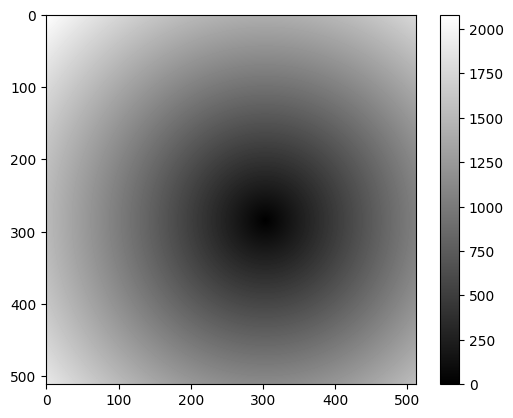

In [145]:
plt.imshow(grad_mask*5,cmap = "gray")
plt.colorbar()
plt.show()

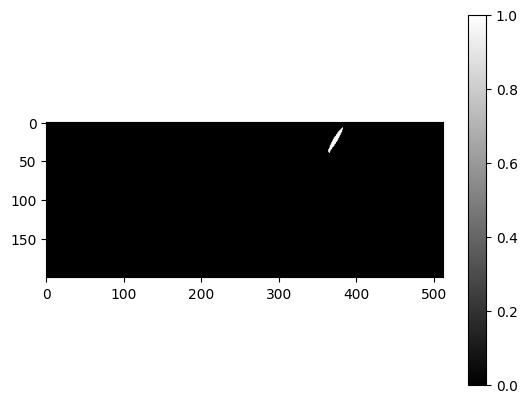

In [403]:
plt.imshow(out_grad_mask[300:500] > 60 ,cmap = "gray")
plt.colorbar()
plt.show()

In [401]:
(1,2)[-1]

2

In [130]:
np.sum(mask)

154.0

In [335]:
mask = torch.Tensor(np.array(g["mask"])).unsqueeze(0)

In [336]:
mask.shape

torch.Size([1, 44, 512, 512])

In [347]:
er = 3
erosion_kernel_t = torch.ones((er,er,er)).unsqueeze(0).unsqueeze(0)
eroded_mask = 1 - torch.clamp(torch.nn.functional.conv3d(1 - mask,erosion_kernel_t , padding=(1,1,1)), 0, 1)




In [348]:
eroded_mask.shape

torch.Size([1, 44, 512, 512])

In [ ]:
plt.imshow()
plt.show()

In [ ]:
plt.imshow(eroded_mask, cmap = "gray")
plt.colorbar()
plt.show()

In [233]:
from scipy import stats
params = (328.5292564674929, -90.53601685038265, 0.47700904381184084)
synthetic_data = stats.gamma.rvs(*params, size=154)
synthetic_data.sort()

In [136]:
mask*newmask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [234]:
A = synthetic_data

In [253]:
A

array([41.76451258, 48.80473515, 49.58041973, 50.90132103, 53.1895637 ,
       53.27681419, 53.45819017, 53.61327775, 53.83344769, 54.18006316,
       54.36211639, 54.37827101, 54.48933873, 54.78034898, 55.27644811,
       55.27710995, 55.83185389, 56.23633898, 56.31927063, 56.33884888,
       56.39703979, 56.87739283, 57.09342741, 57.23765511, 57.7363965 ,
       57.98933746, 58.19054402, 58.26243638, 58.31828746, 58.93076167,
       59.74736176, 59.8342877 , 60.45194159, 60.48922373, 60.62012475,
       60.62965891, 61.08483808, 61.28479193, 61.41111519, 61.70798629,
       61.75034297, 61.76992623, 61.83802902, 61.86820768, 62.2888512 ,
       62.57416616, 62.66426168, 62.68538972, 62.77125245, 62.85685895,
       63.06092807, 63.10643488, 63.37452179, 63.4179754 , 63.42532778,
       63.7067186 , 63.82860327, 64.1528046 , 64.15853312, 64.22043921,
       64.47752166, 64.57936936, 64.81928893, 64.8317415 , 64.90921566,
       64.91470619, 64.99212423, 65.15073413, 65.22969994, 65.29

In [236]:
np.argsort(A)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153])

In [245]:
B = mask*(grad_mask**2)

In [274]:
li = []
for (i,j) in np.argwhere(B>0) :
    li.append((i , j , B[i][j]))

In [276]:
sorted_list = sorted(li, key=lambda x: x[-1])


[(321, 371, 5919.999999999999),
 (323, 370, 5933.0),
 (325, 369, 5956.000000000001),
 (320, 372, 5986.0),
 (327, 368, 5989.000000000001),
 (322, 371, 5993.000000000001),
 (324, 370, 6009.999999999999),
 (329, 367, 6032.0),
 (326, 369, 6036.999999999999),
 (319, 373, 6055.999999999999),
 (321, 372, 6057.0),
 (317, 374, 6065.0),
 (323, 371, 6068.000000000001),
 (328, 368, 6073.999999999999),
 (331, 366, 6085.0),
 (325, 370, 6089.000000000001),
 (327, 369, 6119.999999999999),
 (330, 367, 6121.000000000001),
 (320, 373, 6124.999999999999),
 (318, 374, 6130.0),
 (322, 372, 6130.0),
 (316, 375, 6145.0),
 (324, 371, 6145.0),
 (329, 368, 6161.000000000001),
 (314, 376, 6170.000000000001),
 (326, 370, 6170.000000000001),
 (332, 366, 6177.999999999999),
 (321, 373, 6196.000000000001),
 (319, 374, 6197.000000000001),
 (323, 372, 6205.0),
 (328, 369, 6205.0),
 (317, 375, 6207.999999999999),
 (331, 367, 6212.000000000001),
 (325, 371, 6224.000000000001),
 (315, 376, 6228.999999999999),
 (334, 365, 

In [216]:
flat_B = B.flatten()
sorted_indices = np.argsort(flat_B)

In [242]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich/1.2.840.113619.2.81.290.26072.8890.20140831.200654.h5","r+")

In [244]:
f2["image"]

ValueError: Invalid location identifier (invalid location identifier)

In [217]:
sorted_indices

array([     0, 174806, 174807, ..., 159102, 160637, 174445])

In [224]:
import numpy as np

# Assuming B is your 2D numpy array with non-zero values
# and A is your sorted list of length L

# Flatten B and create an index array for non-zero values
non_zero_indices = np.flatnonzero(B)

# Create an empty array C with the same shape as B
C = np.zeros_like(B)

# Fill C with values from A in the order specified by non-zero values in B
C.flat[non_zero_indices] = A

# Now, C contains values from A in pixel order of B


In [225]:
C

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [170]:
synthetic_data

array([43.92338463, 47.23118699, 47.85018739, 49.78462003, 50.47912031,
       52.30951772, 52.94499738, 53.40519461, 53.55001768, 53.6171727 ,
       53.90708799, 54.44482407, 56.03895294, 56.07960976, 56.13439981,
       56.25493439, 56.25820014, 56.47406138, 56.65319725, 56.76939905,
       57.13112639, 57.24891896, 57.2912159 , 57.35493536, 57.41289334,
       57.61940194, 57.67116659, 57.73184945, 57.74097958, 57.85948694,
       58.42120755, 58.432048  , 58.55887182, 58.92695611, 58.92775146,
       58.93051421, 58.9532011 , 59.13830028, 59.18328294, 60.08501135,
       60.23489031, 60.28511615, 60.34567272, 60.39056369, 60.58204423,
       60.63286746, 60.65323958, 60.98674647, 61.22218175, 61.22705317,
       61.3180911 , 61.5070056 , 61.80275311, 62.10938375, 62.15583976,
       62.38216019, 62.58902009, 62.66837029, 62.72492521, 62.81250979,
       62.82803083, 62.91117751, 63.12168494, 63.1819761 , 63.40687847,
       63.51621686, 63.57019075, 63.6411999 , 63.89687112, 63.97

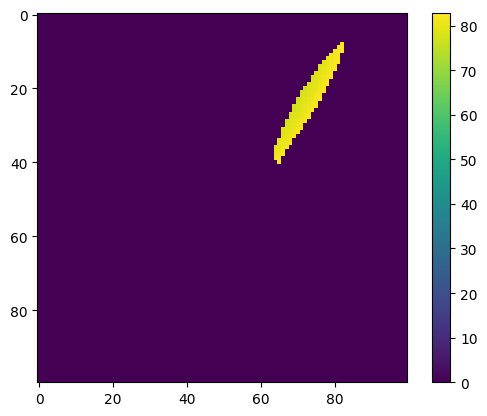

In [288]:
plt.imshow((mask*(grad_mask))[300:400,300:400])
plt.colorbar()
plt.show()

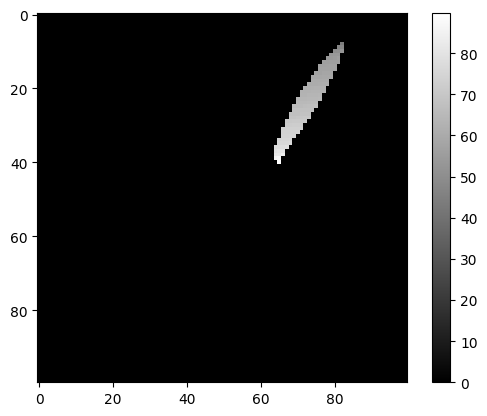

In [227]:
plt.imshow(C[300:400,300:400],cmap ="gray")
plt.colorbar()
plt.show()

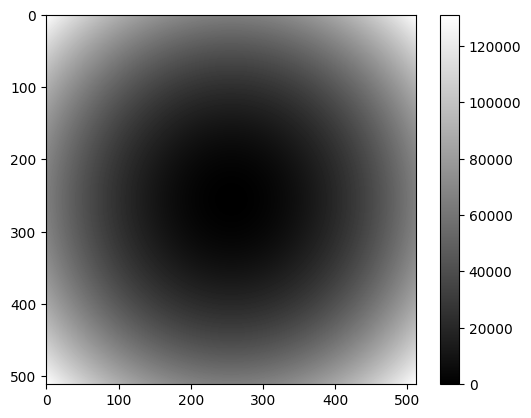

In [151]:
newmask = np.zeros((512, 512))
for i in range(512):
    for j in range(512):
        val = (((256 - i)**2 + (256 - j)**2))
#         print(val)
        newmask[i, j] = val
plt.imshow(newmask, cmap='gray')
plt.colorbar()
plt.show()

In [34]:
a = pd.read_csv("quant_SDH_volume_logits_correction_v4.csv")
# b = pd.read_csv("quant_SDH_volume_logits_correction_v4 copy.csv")

In [25]:
c = pd.concat([a,b]).drop_duplicates()

In [33]:
c.to_csv("quant_SDH_volume_logits_correction_v4.csv" , index =False)

In [30]:
ths = [0.2,0.25,0.3,0.35,0.4,0.45,0.55,0.6]

In [35]:
for th in ths : 
    print(len(a[["StudyUID",f"volume_new_{th}"]][a[f"volume_new_{th}"]>=0]))

5083
5083
5083
5083
5083
5083
5083
5083


In [227]:
plot_scans([blood_window(g["image"]), brain_window(g["image"]) , g["mask"]],["","",""])

interactive(children=(IntSlider(value=0, description='z', max=27), Output()), _dom_classes=('widget-interact',…

In [196]:
grad = np.gradient(g["image"])

In [201]:
len(grad)

3

In [193]:
g["icv_edge"]*g["mask"][16]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

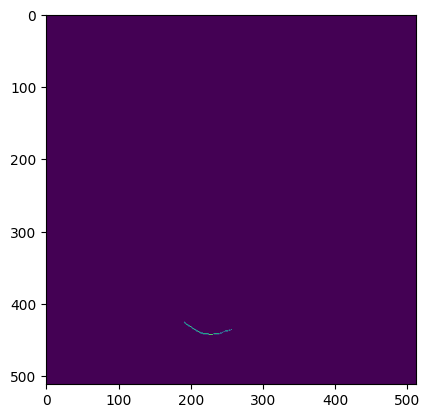

In [194]:
plt.imshow(g["icv_edge"]*g["mask"][16])
plt.show()

In [168]:
params = (328.5292564674929, -90.53601685038265, 0.47700904381184084)
from scipy import stats

synthetic_data = stats.gamma.rvs(*params, size=50)

In [170]:
synthetic_data.sort()

In [171]:
synthetic_data

array([47.83092533, 49.97408658, 52.9950259 , 55.09372739, 55.14846265,
       56.37531688, 56.75012053, 57.29045617, 57.41834058, 58.73128091,
       59.24982393, 59.47165244, 59.47816248, 59.79272811, 60.12992686,
       60.34259847, 60.60972255, 62.27545092, 62.28943469, 64.02336678,
       64.79833508, 65.60734731, 65.81147531, 66.15802909, 66.75472785,
       67.00954457, 67.29781807, 67.52049524, 68.03714957, 68.08463222,
       68.14395821, 68.28398927, 68.29118313, 68.77823719, 69.26633502,
       71.49662233, 71.70831452, 72.44202992, 72.5614441 , 72.80608932,
       72.90032041, 75.08812899, 76.86060023, 80.14184072, 80.93718766,
       83.94838799, 85.22326785, 87.93133508, 89.4533941 , 90.11483873])

In [ ]:
/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv

In [23]:
df_quant_SDH_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/quant_SDH_q25k_outputs.csv")


In [32]:
df_quant_SDH_test

,StudyUID,SeriesUID,volume,unit
0,1.2.840.113619.2.55.3.2831165748.523.145162734...,1.2.840.113619.2.55.3.2831165748.523.145162734...,0.374072,ml
1,1.2.840.113619.2.278.3.2831165733.829.13254451...,1.2.840.113619.2.278.3.2831165733.259.13254455...,0.147049,ml
2,1.2.840.113619.2.100.3.2831165756.679.14518764...,1.2.840.113619.2.100.3.2831165756.679.14518764...,10.911583,ml
3,1.2.840.113619.2.100.3.2831165756.410.14519616...,1.2.840.113619.2.100.3.2831165756.410.14519616...,73.521366,ml
4,1.2.840.10008.1.876202.1773111049.493486925.12...,1.2.840.113619.2.284.3.2831166742.696.13884589...,0.000000,ml
...,...,...,...,...
6260,1.2.840.114350.2.186.2.798268.2.328903589.1,1.2.840.113619.2.55.3.1728712696.136.160172843...,4.670234,ml
6261,1.2.840.114350.2.406.2.798268.2.172376715.1,1.2.392.200036.9116.2.6.1.44063.1805205459.160...,1.207342,ml
6262,1.3.12.2.1107.5.1.4.59737.30000020101411304368...,1.3.12.2.1107.5.1.4.59737.30000020101411321649...,0.000000,ml
6263,2.16.840.1.114151.1041873089863288584464820110...,1.3.12.2.1107.5.1.4.65683.30000020101911100182...,15.049731,ml


In [30]:
df_test = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_test.csv")

In [33]:
a = df_test[df_test.StudyUID.isin(df_quant_SDH_test.StudyUID.values)].StudyUID.values

In [37]:
df_test_SDH = df_quant_SDH_test[df_quant_SDH_test["StudyUID"].isin(a)]

In [38]:
df_test_SDH

,StudyUID,SeriesUID,volume,unit
656,1.2.840.113619.2.22.288.1.8523.20181130.202036,1.2.840.113619.2.22.288.1.8523.2.20181130.202149,0.000000,ml
657,1.2.840.113619.2.22.288.1.8530.20181201.302306,1.2.840.113619.2.22.288.1.8530.2.20181201.302350,0.000000,ml
705,1.2.840.113619.2.81.290.1.14251.20180730.250058,1.2.840.113619.2.81.290.1.14251.2.20180730.250140,11.181450,ml
708,1.2.840.113619.2.81.290.1.14661.20181119.191432,1.2.840.113619.2.81.290.1.14661.2.20181119.191524,5.454319,ml
709,1.2.840.113619.2.81.290.1.14694.20181126.325919,1.2.840.113619.2.81.290.1.14694.2.20181126.330022,2.271652,ml
...,...,...,...,...
6260,1.2.840.114350.2.186.2.798268.2.328903589.1,1.2.840.113619.2.55.3.1728712696.136.160172843...,4.670234,ml
6261,1.2.840.114350.2.406.2.798268.2.172376715.1,1.2.392.200036.9116.2.6.1.44063.1805205459.160...,1.207342,ml
6262,1.3.12.2.1107.5.1.4.59737.30000020101411304368...,1.3.12.2.1107.5.1.4.59737.30000020101411321649...,0.000000,ml
6263,2.16.840.1.114151.1041873089863288584464820110...,1.3.12.2.1107.5.1.4.65683.30000020101911100182...,15.049731,ml


In [39]:
df_test_SDH[(df_test_SDH["volume"] < 0.3) & ()]

,StudyUID,SeriesUID,volume,unit
656,1.2.840.113619.2.22.288.1.8523.20181130.202036,1.2.840.113619.2.22.288.1.8523.2.20181130.202149,0.000000,ml
657,1.2.840.113619.2.22.288.1.8530.20181201.302306,1.2.840.113619.2.22.288.1.8530.2.20181201.302350,0.000000,ml
828,1.2.840.113619.2.22.287.1.28929.20180715.194705,1.2.840.113619.2.22.287.1.28929.2.20180715.194747,0.000000,ml
988,1.3.12.2.1107.5.1.4.34169.4.0.6061104312655291,1.3.12.2.1107.5.1.4.34169.4.0.6075330012385363,0.000000,ml
1000,1.3.12.2.1107.5.1.4.46190.4.0.636527019451476,1.3.12.2.1107.5.1.4.46190.4.0.636960227214541,0.000000,ml
...,...,...,...,...
6238,1.2.392.200036.9116.2.6.1.37.2429916378.160279...,1.2.392.200036.9116.2.6.1.37.2429916378.160279...,0.000000,ml
6239,1.2.392.200036.9116.2.6.1.44063.1805253203.160...,1.2.392.200036.9116.2.6.1.44063.1805253203.160...,0.281973,ml
6245,1.2.840.113619.2.404.3.1695215947.106.16025908...,1.2.840.113619.2.404.3.1695215947.106.16025908...,0.000000,ml
6256,1.2.840.113711.169414.1.11948.622984925.26.211...,1.3.12.2.1107.5.1.4.55491.30000020101602562214...,0.000000,ml


In [686]:
pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/studyuid_report.csv")

,StudyInstanceUID,Report
0,1.2.840.10008.1.13599.764627507.637462589.9966...,{'Text': 'X-RAY CHEST (PA VIEW)\n\n\nThe cardi...
1,1.2.840.10008.1.147142.764627507.371666935.170...,{'Text': 'X-RAY CHEST (PA VIEW)\n\n\nThe cardi...
2,1.2.840.10008.1.164704.764627507.6351410357.10...,{'Text': 'X-RAY CHEST (PA VIEW)\n\n\nThe cardi...
3,1.2.840.10008.1.169493.764627507.437184492.145...,{'Text': 'X-RAY CHEST (PA VIEW)\n\n\nThe cardi...
4,1.2.840.10008.1.227280.764627507.333304910.190...,{'Text': 'X-RAY CHEST (PA VIEW)\n\n\nThe cardi...
...,...,...
6668,1.2.840.113619.2.411.3.346849350.408.164028045...,{'Text': 'PROCEDURE INFORMATION: \nExam:?CT An...
6669,1.2.840.113619.2.411.3.346849350.408.164028045...,{'Text': 'PROCEDURE INFORMATION: \nExam:?CT He...
6670,1.2.840.113619.2.411.3.2831159148.884.15593895...,{'Text': 'IMPRESSION: \n Acute subarachnoid he...
6671,1.2.840.113711.955230084.8648.582276389.26.211...,{'Text': 'EXAM: \n CT Head Without Contrast \n...


In [813]:
df_normal = pd.read_csv("train_normal_ncct.csv")
df_normal = df_normal.sample(5000,random_state=85)

In [814]:
df_normal.StudyUID.values[3500:5000]

array(['1.3.12.2.1107.5.1.4.31128.30000011111304311134300000028',
       '1.3.12.2.1107.5.1.4.40158.4.0.7515976840651565',
       '1.2.840.113619.2.55.3.2831165733.76.1374029251.304', ...,
       '1.3.6.1.4.1.25403.52234692458.1388.20150923040100.1',
       '1.2.840.113619.2.55.3.2831165733.828.1395371281.676',
       '1.2.840.113619.2.55.3.2831165733.25.1424752062.19'], dtype=object)

In [819]:
df_train = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/ICH_dataset_train.csv")

In [817]:
df_normal = pd.read_csv("/home/users/shubham.kumar/projects/qct_training_framework/notebooks/train_normal_ncct.csv")
normal_study_uids = df_normal.sample(5000,random_state=85).StudyUID.values

In [818]:
df_hemorrhage_mask = pd.read_csv("/home/users/shubham.kumar/projects/ICH_classification_segmentation/final_train_val_bleed_pos_seg_dataset.csv")
study_uids_having_bleed_mask = list(set(df_hemorrhage_mask.StudyUID.values))

In [820]:
df_train[df_train["StudyUID"].isin(normal_study_uids)]

,StudyUID,PatientID,Status,Filepath,SeriesUID,Batch,Remarks,ICH,SDH,EDH,...,CONFIRMED_HCT,POSTOP,NORMAL_BRAIN,UNCERTAIN_REPORT,ANY,crop,PATIENT_AGE,MANUFACTURER,ignore,dcmpath
18,1.2.840.10008.1.77735.1190104320.539952723.117...,TCY126126,train,batch_18/sampled/1.2.840.10008.1.77735.1190104...,1.2.840.113619.2.284.3.2831168021.160.13742825...,batch_18,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 28], [64, 488], [90, 418]]",39.000000,GE MEDICAL SYSTEMS,False,batch_18/sampled/1.2.840.10008.1.77735.1190104...
26,1.2.840.113619.2.284.3.2831168021.160.13742825...,TCY126264,train,batch_14/sampled/1.2.840.113619.2.284.3.283116...,1.2.840.113619.2.284.3.2831168021.160.13742825...,batch_14,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 25], [88, 460], [102, 398]]",5.000000,GE MEDICAL SYSTEMS,False,batch_14/sampled/1.2.840.113619.2.284.3.283116...
41,1.2.840.113619.2.55.3.2831165733.81.1374286672...,KUH45485,train,batch_7/sampled/1.2.840.113619.2.55.3.28311657...,1.2.840.113619.2.55.3.2831165733.963.137428748...,batch_7,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 26], [66, 470], [82, 406]]",0.833333,GE MEDICAL SYSTEMS,False,batch_7/sampled/1.2.840.113619.2.55.3.28311657...
68,1.2.840.113619.2.81.290.1.2695.20130720.253020,MDI6560,train,batch_10/sampled/1.2.840.113619.2.81.290.1.269...,1.2.840.113619.2.81.290.1.2695.2.20130720.253321,batch_10,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 32], [72, 486], [96, 426]]",33.000000,GE MEDICAL SYSTEMS,False,batch_10/sampled/1.2.840.113619.2.81.290.1.269...
125,1.2.840.113619.2.25.4.4155979.1325409623.805,KKM1292,train,batch_4/sampled/1.2.840.113619.2.25.4.4155979....,1.2.840.113619.2.25.4.4155979.1325409626.752,batch_4,NaN,0,0,0,...,1,0,1,0.0,0,"[[0, 31], [12, 444], [78, 420]]",41.000000,GE MEDICAL SYSTEMS,False,batch_4/sampled/1.2.840.113619.2.25.4.4155979....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210815,1.3.12.2.1107.5.1.7.106839.3000001905050919373...,A267,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...,1.3.12.2.1107.5.1.7.106839.3000001905050920277...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 26], [0, 486], [50, 392]]",2.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...
210842,1.3.12.2.1107.5.1.7.106839.3000001905090908425...,A309,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...,1.3.12.2.1107.5.1.7.106839.3000001905091227022...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 28], [14, 506], [72, 450]]",17.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...
210867,1.3.12.2.1107.5.1.7.106839.3000001905120914502...,A345,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...,1.3.12.2.1107.5.1.7.106839.3000001905130943458...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 24], [0, 464], [96, 424]]",3.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...
210929,1.3.12.2.1107.5.1.7.106839.3000001905201416278...,A433,train,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...,1.3.12.2.1107.5.1.7.106839.3000001905201547200...,batch_fts_4,nii.gz attempted,0,0,0,...,1,0,1,1.0,0,"[[0, 27], [6, 506], [64, 452]]",26.000000,SIEMENS,False,batch_fts_4/sampled/1.3.12.2.1107.5.1.7.106839...


In [47]:

import pickle
  
# Open the file in binary mode
with open("/cache/fast_data_nas8/qer/shubham/ich_pickle/1.2.840.113619.2.22.288.1.8530.20181201.302306.pkl", "rb") as file:
      
    # Call load method to deserialze
    myvar = pickle.load(file)
  
    print(myvar)

{'results': {'heatmaps': {'acute_mask_logits': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b7a915990> >, 'acute_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799ed210> >, 'acute_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e26c0> >, 'total_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b88f7b600> >, 'total_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e2240> >}, 'quantification value': {'acute_real': 0.0, 'acute_pp': 0.0, 'total_real': 0.0, 'total_pp': 0.0}, 'quantification units': {'ICH': 'ml'}}}


In [48]:
print(myvar)

{'results': {'heatmaps': {'acute_mask_logits': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b7a915990> >, 'acute_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799ed210> >, 'acute_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e26c0> >, 'total_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b88f7b600> >, 'total_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e2240> >}, 'quantification value': {'acute_real': 0.0, 'acute_pp': 0.0, 'total_real': 0.0, 'total_pp': 0.0}, 'quantification units': {'ICH': 'ml'}}}


In [50]:
myvar['results']['heatmaps']

{'acute_mask_logits': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b7a915990> >,
 'acute_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799ed210> >,
 'acute_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e26c0> >,
 'total_real': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b88f7b600> >,
 'total_pp': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f4b799e2240> >}

In [597]:
f2 = h5py.File("/cache/fast_data_nas8/qer/shubham/ich_seg_train_val/1.2.840.10008.1.448965.1404404050.306958935.2069256746.h5","r")



FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/cache/fast_data_nas8/qer/shubham/ich_seg_train_val/1.2.840.10008.1.448965.1404404050.306958935.2069256746.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
f